# KGE Training and Inference on OGBL-BioKG

<em>Copyright (c) 2023 Graphcore Ltd. All rights reserved.</em>

BESS-KGE (`besskge`) is a PyTorch library for knowledge graph embedding (KGE) models on IPUs implementing the distribution framework [BESS](https://arxiv.org/abs/2211.12281), with embedding tables stored in the IPU SRAM.

In this notebook we will learn how to use the BESS-KGE library to train KGE models and perform link prediction inference, using the biomedical dataset [ogbl-biokg](https://ogb.stanford.edu/docs/linkprop/#ogbl-biokg).

## Environment setup

The best way to run this demo is on Paperspace Gradient's cloud IPUs because everything is already set up for you.

 [![Run on Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/graphcore-research/bess-kge?container=graphcore%2Fpytorch-jupyter%3A3.2.0-ubuntu-20.04&machine=Free-IPU-POD4&file=%2Fnotebooks%2F1_biokg_training_inference.ipynb)

To run the demo using other IPU hardware, you need to have the Poplar SDK enabled and a PopTorch wheel installed. Refer to the [Getting Started guide](https://docs.graphcore.ai/en/latest/getting-started.html#getting-started) for your system for details on how to do this. Also refer to the [Jupyter Quick Start guide](https://docs.graphcore.ai/projects/jupyter-notebook-quick-start/en/latest/index.html) for how to set up Jupyter to be able to run this notebook on a remote IPU machine.

## Dependencies

We recommend that you install `besskge` directly from the GitHub sources:

In [1]:
import sys
!{sys.executable} -m pip uninstall -y besskge
!pip install -q git+https://github.com/graphcore-research/bess-kge.git

!pip install -q matplotlib

Found existing installation: besskge 0.1
Uninstalling besskge-0.1:
  Successfully uninstalled besskge-0.1


Next, import the necessary dependencies. 

In [3]:
import os
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import poptorch
import torch

from besskge.batch_sampler import RigidShardedBatchSampler
from besskge.bess import EmbeddingMovingBessKGE, ScoreMovingBessKGE
from besskge.dataset import KGDataset
from besskge.embedding import UniformInitializer
from besskge.loss import LogSigmoidLoss
from besskge.metric import Evaluation
from besskge.negative_sampler import (
    RandomShardedNegativeSampler,
    TripleBasedShardedNegativeSampler,
)
from besskge.scoring import RotatE
from besskge.sharding import PartitionedTripleSet, Sharding

dataset_directory = os.getenv("DATASETS_DIR", "../datasets/") + "/biokg/"

## Sharding entities and triples

The OGBL-BioKG dataset can be downloaded and preprocessed with the built-in `KGDataset` method, `build_biokg`. `KGDataset` is the standard class which holds data from the KG dataset, such as head-relation-tail triples (with entities and relation types suitably converted to their integer IDs), triple-specific data (for example negative heads/tails to be used to corrupt the triple), ID -> label lists for entities and relation types, and so on.

In [8]:
biokg = KGDataset.build_biokg(root=pathlib.Path(dataset_directory))

print(f"Number of entities: {biokg.n_entity:,}\n")
print(f"Number of relation types: {biokg.n_relation_type}\n")
print(f"Number of triples: \n training: {biokg.triples['train'].shape[0]:,} \n validation/test: {biokg.triples['valid'].shape[0]:,}\n")
print(f"Number of negative heads/tails for validation/test triples: {biokg.neg_heads['valid'].shape[-1]}")

Number of entities: 93,773

Number of relation types: 51

Number of triples: 
 training: 4,762,678 
 validation/test: 162,886

Number of negative heads/tails for validation/test triples: 500


Entities in the OGBL-BioKG dataset have different types. Entity IDs need to be always assigned so that entities of the same type have contiguous IDs. Then, the ID offsets corresponding to different types are stored in `KGDataset.type_offsets`:

In [3]:
biokg.type_offsets

{'disease': 0,
 'drug': 10687,
 'function': 21220,
 'protein': 66305,
 'sideeffect': 83804}

For example, entities with ID in the range [0, 10686] are of type 'disease'.

To train on 4 IPUs, we shard the entity set into four parts of equal size. This is done using the `Sharding` class. To use a different number of IPUs, just change the value of the `n_shard` variable.

In [6]:
seed = 1234
n_shard = 4

sharding = Sharding.create(n_entity=biokg.n_entity, n_shard=n_shard, seed=seed, type_offsets=np.fromiter(biokg.type_offsets.values(), dtype=np.int32))

print(f"Number of shards: {sharding.n_shard}\n")

print(f"Number of entities in each shard: {sharding.max_entity_per_shard:,}\n")

print(f"Global entity IDs on {n_shard} shards:\n {sharding.shard_and_idx_to_entity}\n")

# If the number of entities is not divisible by n_shard, some shards will have one trailing padding entity (ID >= n_entity)
print(f"Number of actual (=non-padding) entities per shard:\n {sharding.shard_counts}\n")

# Entities of the same type maintain contiguous local IDs in each shard
print(f"Type offsets per shard: \n", sharding.entity_type_offsets)

Number of shards: 4

Number of entities in each shard: 23,444

Global entity IDs on 4 shards:
 [[    0     4    12 ... 93769 93773 93774]
 [    8    11    18 ... 93762 93771 93775]
 [    1     2     9 ... 93761 93764 93772]
 [    3     5     6 ... 93767 93768 93770]]

Number of actual (=non-padding) entities per shard:
 [23443 23443 23444 23444]

Type offsets per shard: 
 [[    0  2689  5350 16623 20984]
 [    0  2733  5240 16383 20862]
 [    0  2631  5323 16657 20991]
 [    0  2634  5307 16642 20967]]


Since the total number of entities (93,773) is not divisible by `n_shard` (4), some padding entities are created. These entities have global entity IDs with values greater than or equal to 93,773 and can be seen printed above.

The entity sharding induces a partitioning of the set of training triples into `n_shard ** 2 = 16` **shard-pairs**, based on the entity shard of the head and of the tail. Triple partitioning is performed using the `PartitionedTripleSet` class.

<p align="left">
<img src="https://raw.githubusercontent.com/graphcore-research/bess-kge/main/notebooks/img/batch.png"  width="500" >
</p>

In [5]:
train_triples = PartitionedTripleSet.create_from_dataset(dataset=biokg, part="train", sharding=sharding, partition_mode="ht_shardpair")

# train_triples.triple_counts[i,j] is the number of triples with head entity in shard i and tail entity in shard j
print(f"Number of triples per (h,t) shard-pair:\n {train_triples.triple_counts}")

Number of triples per (h,t) shardpair:
 [[291989 290598 314459 278671]
 [294571 292577 314075 280268]
 [313333 308181 331824 296695]
 [287855 286280 307383 273919]]


Triples in `train_triples.triples` have been sorted based on the sequence of (h,t) shard-pairs: `(0,0), (0,1), ..., (n_shard-1, n_shard-1)`. You can use `train_triples.triple_sort_idx` to recover the original ordering.

Moreover, the global entity IDs for heads and tails have been replaced with the local indices on the corresponding shard.

In [6]:
# Put original triples in the same order as train_triples.triples
triple_sorted = biokg.triples["train"][train_triples.triple_sort_idx]
# Pass from global IDs to local IDs with sharding.entity_to_idx
triple_sorted[:,0] = sharding.entity_to_idx[triple_sorted[:,0]]
triple_sorted[:,2] = sharding.entity_to_idx[triple_sorted[:,2]]
# Compare with the content of train_triples.triples
np.all(triple_sorted == train_triples.triples)

True

## Negative and batch samplers

A key component in training KGE models is the selection of negative samples to contrast against positive triples. A standard strategy to construct negative samples is to replace (corrupt) either the head or the tail of a positive triple with another entity.

To sample the negative entities used to corrupt positive triples, we use a **negative sampler**. You can find different types of negative samplers implemented in `besskge.negative_sampler`. Two suitable samplers are:

* `RandomShardedNegativeSampler`, which randomly picks the negative entity among all the entities in the KG;
* `TypeBasedShardedNegativeSampler`, which selects the corrupted entity only among entities of the same type as the original one.

By default, BESS samples the same number of negative entities from each entity shard, to minimize selection bias. For each pair of devices, the same amount of negative entities is exchanged in both directions, through collective operators.

* If `flat_negative_format=False`, negative entities are sampled on a triple basis. For each positive triple in a micro-batch, `n_negative` corrupted entities are received from each device, for a total of `shard_bs * n_negative * n_shard` negatives used in the micro-batch. We can then decide whether to score each of the `shard_bs` triples in the micro-batch only against the corresponding `n_negative * n_shard` negative entities, or against all negatives seen in the micro-batch (**negative sample sharing**).

* If `flat_negative_format=True`, negative entities are sampled on a shard-pair basis. Each device receives `n_negative` negatives from each shard, for a total of `n_negative * n_shard` negatives used in the micro-batch. As the negatives are not sampled on a triple basis, this requires the use of negative sample sharing.

In order to reduce inter-device communication, we have the option of sampling all negatives just from the device where the triple loss will be computed, by setting `local_sampling=True`. This, however, introduces a bias in the construction of negative samples.

When instantiating the negative sampler, we must also specify the corruption scheme:
* `corruption_scheme='h'` if negative samples are to be constructed by corrupting the head entity;
* `corruption_scheme='t'` if negative samples are to be constructed by corrupting the tail entity;
* `corruption_scheme='ht'` if negative samples are to be constructed by corrupting the head entity for half the triples in the micro-batch and the tail entity for the other half (in this case, when using negative sample sharing, negatives are shared only among the triples in the same half).

In [7]:
neg_sampler = RandomShardedNegativeSampler(n_negative=1, sharding=sharding, seed=seed, corruption_scheme="ht",
                                           local_sampling=False, flat_negative_format=False)

In order to start training, we are missing only one component: a **batch sampler**. This class is responsible for cooking up the batches to pass to each device. This is not a trivial task, since at each step each device needs to know which embeddings stored in its local memory are needed by itself and by all other devices.
Different types of batch samplers are implemented in `besskge.batch_sampler`. All of them, at each step, sample the same number of triples from each of the 16 shard-pair buckets. Here we use `RigidShardedBatchSampler`, where each bucket is consumed sequentially. The length of an epoch is then dictated by the length of the largest bucket.

In [8]:
device_iterations = 8
accum_factor = 6
# Micro-batch size, which means the number of positive triples processed on each device at each step
shard_bs = 240

batch_sampler = RigidShardedBatchSampler(partitioned_triple_set=train_triples, negative_sampler=neg_sampler,
                              shard_bs=shard_bs, batches_per_step=device_iterations*accum_factor, seed=seed)


print(f"# triples per shard-pair per step: {batch_sampler.positive_per_partition} \n")

# Example batch
idx_sampler = iter(batch_sampler.get_dataloader_sampler(shuffle=True))
for k,v in batch_sampler[next(idx_sampler)].items():
    print(f"{k:<12} {str(v.shape):<30} {v.dtype};")

# triples per shardpair per step: 60 

head         torch.Size([48, 4, 4, 60])     torch.int32;
relation     torch.Size([48, 4, 4, 60])     torch.int32;
tail         torch.Size([48, 4, 4, 60])     torch.int32;
triple_mask  torch.Size([48, 4, 4, 60])     torch.bool;
negative     torch.Size([48, 4, 4, 240, 1]) torch.int32;


We see that each call returns `device_iterations * accum_factor = 48` batches. Each of them is composed of 60 triples from each of the 16 shard-pair buckets. In particular, IPU `i` will process 240 triples, 60 from each of the four (h, t) shard-pairs `(i,0), (i,1), (i,2), (i,3)`. 

`head[:,i,:,:], tail[:,i,:,:]` are the entity IDs of the embeddings that need to be gathered from the SRAM of IPU `i`.

`negative[:,i,j,t,:]` are the negative entities sampled on IPU `i` to be used for triple `t` on IPU `j` (where the trailing 1 is the `n_negative` specified in the negative sampler).

`triple_mask` is a boolean mask indicating which of the positive triples in the batch are non-padding (since, as mentioned above, `RigidShardedBatchSampler` will repeat triples in smaller shard-pair buckets during an epoch). We can ignore it during training, but it is important at inference time, when we want to visit each triple only once. We can then use `triple_mask` to discard any duplicates.


<p align="left">
<img src="https://raw.githubusercontent.com/graphcore-research/bess-kge/main/notebooks/img/negsplit.png"  width="880" >
</p>

## Distributed training

The method `get_dataloader` of the batch sampler returns the PopTorch dataloader which we iterate over during training.

In [8]:
options = poptorch.Options()
options.replication_factor = sharding.n_shard
options.deviceIterations(device_iterations)
options.Training.gradientAccumulation(accum_factor)
# Add a memory saving optimisation pattern. This removes an unnecessary
# entity_embedding gradient all-reduce, which is a no-op since it is fully
# sharded across replicas.
options._popart.setPatterns(dict(RemoveAllReducePattern=True))

# Construction similar to PyTorch dataloader
train_dl = batch_sampler.get_dataloader(options=options, shuffle=True, num_workers=5, persistent_workers=True)

We are now ready to define the model and train it. We'll use **RotatE** with (real) 128-dimensional embeddings and the **logsigmoid** loss function with **negative adversarial sampling**. We will also use **negative sample sharing** within the micro-batches to increase the effective number of negative samples without the need for sampling and exchanging more negative entities.

The **BESS distribution scheme** is implemented in `besskge.bess` and it works as a wrapper around the KGE scoring function. It comes in different flavours: here we use the basic `EmbeddingMovingBessKGE` class, where entity embeddings are exchanged between IPUs (from the one where the embedding is stored to the one where it is needed for computation) through AllToAll collectives (for details on the embedding sharing, see the [BESS-KGE documentation](https://graphcore-research.github.io/bess-kge/API_ref/bess.html)).

In [10]:
# Loss function
logsigmoid_loss_fn = LogSigmoidLoss(margin=12.0, negative_adversarial_sampling=True)
# Initialization scheme for embedding tables
emb_initializer = UniformInitializer(range_scale=logsigmoid_loss_fn.margin)
# KGE model
rotate_score_fn = RotatE(negative_sample_sharing=True, scoring_norm=1, sharding=sharding,
                  n_relation_type=biokg.n_relation_type, embedding_size=128,
                  entity_initializer=emb_initializer, relation_initializer=emb_initializer)
# BESS wrapper
model = EmbeddingMovingBessKGE(negative_sampler=neg_sampler, score_fn=rotate_score_fn,
                               loss_fn=logsigmoid_loss_fn)

# Optimizer
opt = poptorch.optim.AdamW(
        model.parameters(),
        lr=0.001,
    )

# PopTorch wrapper
poptorch_model = poptorch.trainingModel(model, options=options, optimizer=opt)

# The variable entity_embedding needs to hold different values on each replica,
# corresponding to the distinct shards of the entity embedding table
poptorch_model.entity_embedding.replicaGrouping(
            poptorch.CommGroupType.NoGrouping,
            0,
            poptorch.VariableRetrievalMode.OnePerGroup,
        )

# Compile model
batch = next(iter(train_dl))
_ = batch.pop("triple_mask")
#  PopTorch requires to flatten device_iterations and shard into a single dimension
res = poptorch_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})

Graph compilation: 100%|██████████| 100/100 [00:59<00:00]


Epoch 1 loss: 0.698177 --- positive triples processed: 5.35e+06
Epoch duration (sec): 1.95775 (average step time: 0.01533)
Epoch 2 loss: 0.472533 --- positive triples processed: 1.07e+07
Epoch duration (sec): 1.77420 (average step time: 0.01523)
Epoch 3 loss: 0.408885 --- positive triples processed: 1.60e+07
Epoch duration (sec): 1.77967 (average step time: 0.01523)
Epoch 4 loss: 0.386156 --- positive triples processed: 2.14e+07
Epoch duration (sec): 1.75322 (average step time: 0.01505)
Epoch 5 loss: 0.370855 --- positive triples processed: 2.67e+07
Epoch duration (sec): 1.74845 (average step time: 0.01502)
Epoch 6 loss: 0.367683 --- positive triples processed: 3.21e+07
Epoch duration (sec): 1.75177 (average step time: 0.01502)
Epoch 7 loss: 0.364207 --- positive triples processed: 3.74e+07
Epoch duration (sec): 1.75988 (average step time: 0.01511)
Epoch 8 loss: 0.360826 --- positive triples processed: 4.28e+07
Epoch duration (sec): 1.75050 (average step time: 0.01502)
Epoch 9 loss: 0.

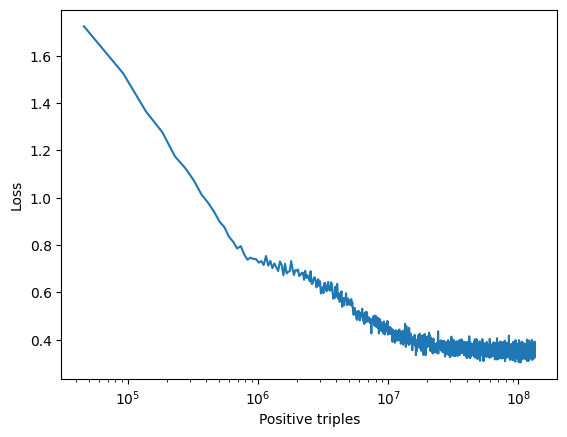

In [11]:
# Train for 25 epochs
n_epochs = 25

# Positive triples seen until now
cumulative_triples = 0
training_loss = []
for ep in range(n_epochs):
    ep_start_time = time.time()
    ep_log = []
    for batch in train_dl:
        step_start_time = time.time()
        # triple_mask is not used during training
        triple_mask = batch.pop("triple_mask")
        cumulative_triples += triple_mask.numel()
        res = poptorch_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})
        # res["loss"] contains the summed loss of elements in the last batch, for each IPU
        ep_log.append(dict(loss=float(torch.sum(res["loss"])) / triple_mask[-1].numel(), step_time=(time.time()-step_start_time)))
    ep_loss = [v['loss'] for v in ep_log]
    training_loss.extend([v['loss'] for v in ep_log])
    print(f"Epoch {ep+1} loss: {np.mean(ep_loss):.6f} --- positive triples processed: {cumulative_triples:.2e}")
    print(f"Epoch duration (sec): {(time.time() - ep_start_time):.5f} (average step time: {np.mean([v['step_time'] for v in ep_log]):.5f})")

# Plot loss as a function of the number of positive triples processed
total_triples = np.cumsum(n_epochs * len(train_dl) * [triple_mask.numel()])
ax = plt.gca()
ax.plot(total_triples, training_loss)
ax.set_xscale("log")
ax.set_xlabel("Positive triples")
ax.set_ylabel("Loss")

poptorch_model.detachFromDevice()
del train_dl

## Inference

Let's see now how the trained model performs on the **validation** set. 

We create a new `PartitionedTripleSet` holding the validation triples. Differently from the training set, each validation triple has a specific set of 500 negative heads/tails to be scored against, hence we use the `TripleBasedShardedNegativeSampler` negative sampler class to sample exactly the negative entities needed by each triple. This means that we will not be using negative sample sharing any more.

For the batch sampler, we again use the `RigidShardedBatchSampler` class, but we now set the option `duplicate_batch=True`. This means that the two halves of the micro-batch (where we corrupt heads and tails respectively) contain the same positive triples, so that we can score negative heads and negative tails with a single model.

In [12]:
valid_triples = PartitionedTripleSet.create_from_dataset(dataset=biokg, part="valid", sharding=sharding, partition_mode="ht_shardpair")
ns_valid = TripleBasedShardedNegativeSampler(negative_heads=valid_triples.neg_heads, negative_tails=valid_triples.neg_tails,
                                             sharding=sharding, corruption_scheme="ht", seed=seed)
bs_valid = RigidShardedBatchSampler(partitioned_triple_set=valid_triples, negative_sampler=ns_valid, shard_bs=shard_bs, batches_per_step=10,
                                    seed=seed, duplicate_batch=True)

# Example batch
idx_sampler = iter(bs_valid.get_dataloader_sampler(shuffle=False))
for k,v in bs_valid[next(idx_sampler)].items():
    print(f"{k:<15} {str(v.shape):<35} {v.dtype};")

head            torch.Size([10, 4, 4, 60])          torch.int32;
relation        torch.Size([10, 4, 4, 60])          torch.int32;
tail            torch.Size([10, 4, 4, 60])          torch.int32;
triple_mask     torch.Size([10, 4, 4, 60])          torch.bool;
negative        torch.Size([10, 4, 4, 240, 175])    torch.int32;
negative_mask   torch.Size([10, 4, 240, 4, 175])    torch.bool;


We see that the `negative` tensor returned now by the dataloader has a trailing dimension of 175, meaning that each validation query is scored against `4*175` negative heads/tails, which is larger than 500. This is due to the fact that the triple-specific negatives are, in general, not equally split between the 4 shards, therefore some padding needs to be applied. `negative_mask` returned by the negative sampler is used to identify the padding negative entities, so that the corresponding scores can be filtered out when computing the metrics.

We can now instantiate the inference model. We use the `besskge.metric.Evaluation` class to specify which **metrics** we want to compute and pass it to the BESS module. Here we look at Hits@K for K=1,5,10, giving us the percentage of the validation triples where the ground truth head/tail is among the K most-likely predictions made by the model, and the mean reciprocal rank (MRR). For all these metrics, **higher is better**. By specifying `reduction="sum"` we reduce communication between host and device, by returning the summed values, over the elements in the same micro-batch, for each metric.

We now use a different flavour of BESS compared to training, namely `ScoreMovingBessKGE`. This is recommended when the number of negative entities to be fetched from other devices is large, as it is typically the case when using `TripleBasedShardedNegativeSampler`. While `EmbeddingMovingBessKGE` sends the negative embeddings to the device where the positive triple is scored, `ScoreMovingBessKGE` fetches the queries with an AllGather and computes negative scores on the shard where the negative entities are stored, and then sends the scores back to the original device. This allows for communicating of scores instead of embeddings, which is usually cheaper, although it requires additional collective communications between devices. We encourage you to play with different configurations to see which one gives the shorter overall validation time.

In [13]:
# Each triple is now to be scored against a specific set of negatives, so we turn off negative sample sharing
rotate_score_fn.negative_sample_sharing = False

val_options = poptorch.Options()
val_options.replication_factor = sharding.n_shard
val_options.deviceIterations(bs_valid.batches_per_step)
val_options.outputMode(poptorch.OutputMode.All)

# Validation dataloader
valid_dl = bs_valid.get_dataloader(options=val_options, shuffle=False, num_workers=3, persistent_workers=True)

# With reduction="sum" the returned res["metrics"] has shape (batches_per_step * n_shard, n_metrics)
evaluator = Evaluation(["mrr", "hits@1", "hits@5", "hits@10"], reduction="sum")
# BESS wrapper
model_inf = ScoreMovingBessKGE(negative_sampler=ns_valid, score_fn=rotate_score_fn, evaluation=evaluator)

# PopTorch wrapper
poptorch_model_inf = poptorch.inferenceModel(model_inf, options=val_options)
poptorch_model_inf.entity_embedding.replicaGrouping(
            poptorch.CommGroupType.NoGrouping,
            0,
            poptorch.VariableRetrievalMode.OnePerGroup,
        )

# Compile model
batch = next(iter(valid_dl))
res = poptorch_model_inf(**{k: v.flatten(end_dim=1) for k, v in batch.items()})

[11:29:42.997] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 435
[11:29:43.009] [poptorch:cpp] [warning] [DISPATCHER] Type coerced from Long to Int for tensor id 441
Graph compilation: 100%|██████████| 100/100 [00:56<00:00]


In [14]:
# Perform validation and print metrics

val_log = []
# The final value of n_val_queries will be twice the number of triples in the validation set
# as each triple is scored against negative heads and negative tails separately
n_val_queries = 0
for batch_val in valid_dl:
    res = poptorch_model_inf(**{k: v.flatten(end_dim=1) for k, v in batch_val.items()})
    
    n_val_queries += batch_val["triple_mask"].sum()
    # By transposing res["metrics"] we separate the outputs for the different metrics
    val_log.append({k: v.sum() for k, v in zip(
                        evaluator.metrics.keys(),
                        res["metrics"].T,
                    )})

for metric in val_log[0].keys():
    reduced_metric = sum([l[metric] for l in val_log]) / n_val_queries
    print("%s : %f" % (metric, reduced_metric))

poptorch_model_inf.detachFromDevice()
del valid_dl

hits@1 : 0.745279
hits@5 : 0.905296
hits@10 : 0.941364
mrr : 0.816847


## How many parameters does our model have?

We can see how many parameters the model has:

In [15]:
# Equivalent to sum(p.numel() for p in model_inf.parameters()), as embeddings are the only trainable parameters
print(f"# model parameters: {model_inf.n_embedding_parameters:,}")

# model parameters: 12,006,592


Looking at the [OGB leaderboard](https://ogb.stanford.edu/docs/leader_linkprop/#ogbl-biokg) for the OGBL-BioKG dataset, the validation MRR we got is **very competitive even when compared against other classical shallow KGE models with 15 times more parameters** than we used. Not bad for a model we trained so quickly!

## Scaling analysis

The OGBL-BioKG knowledge graph is small enough that we can actually train the model above (with same embedding size) on a single IPU. This allows us to get a better grasp on the advantages of distribution.

In order to train on one IPU, we just need to set `n_shard = 1` when defining the `Sharding` of the entity table.

In [16]:
n_shard = 1

sharding = Sharding.create(n_entity=biokg.n_entity, n_shard=n_shard, seed=seed, type_offsets=np.fromiter(biokg.type_offsets.values(), dtype=np.int32))

print(f"Number of shards: {sharding.n_shard}\n")

# All entities in the KG are now on a single shard
print(f"Number of entities in each shard: {sharding.max_entity_per_shard}\n")

train_triples = PartitionedTripleSet.create_from_dataset(dataset=biokg, part="train", sharding=sharding, partition_mode="ht_shardpair")

# There is now a single (h,t) shard-pair, containing all training triples 
print(f"Number of triples per (h,t) shard-pair:\n {train_triples.triple_counts}")

Number of shards: 1

Number of entities in each shard: 93773

Number of triples per (h,t) shardpair:
 [[4762678]]


As explained in the section [Negative and batch samplers](#negative-and-batch-samplers), in order to score each triple against the same number of negatives as before, we need to multiply `n_negative` by 4.

In [17]:
# Reducing the number of shards by a factor of 4, the number of negatives per triple per shard (i.e. n_negative) needs to increase by the same factor
neg_sampler = RandomShardedNegativeSampler(n_negative=4, sharding=sharding, seed=seed, corruption_scheme="ht",
                                           local_sampling=False, flat_negative_format=False)

Similarly, since we maintain the same micro-batch size used before (to get a fair comparison using negative sample sharing), we multiply the accumulation factor by 4 so that the global batch size is the same.

In [18]:
device_iterations = 8
accum_factor = 24
shard_bs = 240

batch_sampler = RigidShardedBatchSampler(partitioned_triple_set=train_triples, negative_sampler=neg_sampler,
                              shard_bs=shard_bs, batches_per_step=device_iterations*accum_factor, seed=seed)


print(f"# triples per shard-pair per step: {batch_sampler.positive_per_partition} \n")

# Example batch
idx_sampler = iter(batch_sampler.get_dataloader_sampler(shuffle=True))
for k,v in batch_sampler[next(idx_sampler)].items():
    print(f"{k:<12} {str(v.shape):<30} {v.dtype};")

# triples per shardpair per step: 240 

head         torch.Size([192, 1, 1, 240])   torch.int32;
relation     torch.Size([192, 1, 1, 240])   torch.int32;
tail         torch.Size([192, 1, 1, 240])   torch.int32;
triple_mask  torch.Size([192, 1, 1, 240])   torch.bool;
negative     torch.Size([192, 1, 1, 240, 4]) torch.int32;


The dataloader and model are created exactly as before.

In [19]:
options = poptorch.Options()
options.deviceIterations(device_iterations)
options.Training.gradientAccumulation(accum_factor)

train_dl = batch_sampler.get_dataloader(options=options, shuffle=True, num_workers=5, persistent_workers=True)

logsigmoid_loss_fn = LogSigmoidLoss(margin=12.0, negative_adversarial_sampling=True)
emb_initializer = UniformInitializer(range_scale=logsigmoid_loss_fn.margin)
rotate_score_fn = RotatE(negative_sample_sharing=True, scoring_norm=1, sharding=sharding,
                  n_relation_type=biokg.n_relation_type, embedding_size=128,
                  entity_initializer=emb_initializer, relation_initializer=emb_initializer)

model = EmbeddingMovingBessKGE(negative_sampler=neg_sampler, score_fn=rotate_score_fn,
                               loss_fn=logsigmoid_loss_fn)

opt = poptorch.optim.AdamW(
        model.parameters(),
        lr=0.001,
    )

poptorch_model = poptorch.trainingModel(model, options=options, optimizer=opt)
poptorch_model.entity_embedding.replicaGrouping(
            poptorch.CommGroupType.NoGrouping,
            0,
            poptorch.VariableRetrievalMode.OnePerGroup,
        )


# Compile model
batch = next(iter(train_dl))
_ = batch.pop("triple_mask")
res = poptorch_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})

Graph compilation: 100%|██████████| 100/100 [01:01<00:00]


In [20]:
# Train for the first 10 epochs
n_epochs = 10

cumulative_triples = 0
training_loss = []
for ep in range(n_epochs):
    ep_start_time = time.time()
    ep_log = []
    for batch in train_dl:
        step_start_time = time.time()
        triple_mask = batch.pop("triple_mask")
        cumulative_triples += triple_mask.numel()
        res = poptorch_model(**{k: v.flatten(end_dim=1) for k, v in batch.items()})
        ep_log.append(dict(loss=float(torch.sum(res["loss"])) / triple_mask[-1].numel(), step_time=(time.time()-step_start_time)))
    ep_loss = [v['loss'] for v in ep_log]
    training_loss.extend([v['loss'] for v in ep_log])
    print(f"Epoch {ep+1} loss: {np.mean(ep_loss):.6f} --- positive triples processed: {cumulative_triples:.2e}")
    print(f"Epoch duration (sec): {(time.time() - ep_start_time):.5f} (average step time: {np.mean([v['step_time'] for v in ep_log]):.5f})")

poptorch_model.detachFromDevice()
del train_dl

Epoch 1 loss: 0.711565 --- positive triples processed: 4.79e+06
Epoch duration (sec): 5.97384 (average step time: 0.05022)
Epoch 2 loss: 0.497848 --- positive triples processed: 9.58e+06
Epoch duration (sec): 5.20361 (average step time: 0.04997)
Epoch 3 loss: 0.423704 --- positive triples processed: 1.44e+07
Epoch duration (sec): 5.19094 (average step time: 0.04985)
Epoch 4 loss: 0.390434 --- positive triples processed: 1.92e+07
Epoch duration (sec): 5.18438 (average step time: 0.04979)
Epoch 5 loss: 0.380970 --- positive triples processed: 2.40e+07
Epoch duration (sec): 5.20511 (average step time: 0.04998)
Epoch 6 loss: 0.371948 --- positive triples processed: 2.88e+07
Epoch duration (sec): 5.19947 (average step time: 0.04992)
Epoch 7 loss: 0.371240 --- positive triples processed: 3.35e+07
Epoch duration (sec): 5.19853 (average step time: 0.04992)
Epoch 8 loss: 0.362567 --- positive triples processed: 3.83e+07
Epoch duration (sec): 5.19344 (average step time: 0.04987)
Epoch 9 loss: 0.

By comparing the epoch durations, we see that **scaling from 1 to 4 IPUs speeds up training by a factor of ~3X**. This is actually a conservative estimate, because - as one can notice from the printouts - the number of triples processed at each epoch is larger when running on 4 IPUs, as a consequence of using `RigidShardedBatchSampler` (the number of triples seen during an epoch is determined by the number of triples in the largest shard-pair bucket).

## Conclusions and next steps

To recap, these are the basic steps to run distributed training/inference with BESS-KGE:
* wrap your KG dataset with `besskge.dataset.KGDataset`;
* shard entities in the graph based on the number of IPUs you want to use, by using `besskge.sharding.Sharding`, and partition triples accordingly with `besskge.sharding.PartitionedTripleSet`;
* select a negative sampler from `besskge.negative_sampler` to sample the entities used to corrupt positive triples;
* use a batch sampler from `besskge.batch_sampler` to create the batch dataloader; 
* specify the scoring and loss function (see `besskge.scoring` and `besskge.loss`) and initialize the embedding tables, either from an existing checkpoint or with one of the initialization schemes from `besskge.embedding.EmbeddingInitializer`;
* instantiate the distributed model with one of the subclasses of `besskge.bess.BessKGE`.

You can easily modify this notebook to use different combinations of KGE models, embedding sizes and loss functions, change the number of negative samples or the sampling scheme (for instance, try training with `TypeBasedShardedNegativeSampler`).

What next? If you are interested in using these models to complete queries when no candidate heads/tails are provided, have a look at the the [Knowledge Graph Completion on YAGO3-10](2_yago_topk_prediction.ipynb) notebook. For using FP16 embeddings to deal with larger graphs, look at the [FP16 embeddings on OGBL-WikiKG2](3_wikikg2_fp16.ipynb) notebook.